# 1.ICESAT-2有效波高显示

## 变量说明
### 前缀
hy_     HY-2B卫星
cy_     CryoSat-2卫星
什么都没有的是ICESAT-2卫星

### 后缀
_west    代表西半球

In [ ]:
import pyproj
from  pyproj  import  CRS
from pyproj import Proj
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset

In [140]:
"读取单个h5文件并可视化,最后图像为一条轨道上的数据"

dir_path = '.\H2B_nc_data\ICESAT2_ATL12_20200711'
ncfiles = glob.glob(dir_path + '\*.h5')
lon_array = np.array([])

lat_array = np.array([])
swh_array = np.array([])
for ncfile in ncfiles:
    with h5py.File(ncfile, 'r') as f:
        lats = f['gt2l']['ssh_segments']['latitude'][:]
        lons = f['gt2l']['ssh_segments']['longitude'][:]
        swh = f['gt2l']['ssh_segments']['heights']['swh'][:]
    lon_array = np.append(lon_array, lons)
    lat_array = np.append(lat_array, lats)
    swh_array = np.append(swh_array, swh)


In [141]:
# 将WGS 84坐标（4326）转化为等距圆柱投影（4088）
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = pyproj.Transformer.from_crs(crs,crs2)
projlats,projlons = transformer.transform(lat_array,lon_array)

In [142]:
# 设置空间分辨率
resolution = 10000
# pb_lat_max, pb_lat_min, pb_lon_max, pb_lon_min = 20003989.28 , -20003989.28, 9451579.15, -9451579.15
# nlat, nlon = np.int((pb_lat_max-pb_lat_min ) / resolution), np.int((pb_lon_max - pb_lon_min) / resolution)
nlat, nlon =(projlats.max()-projlats.min())/resolution, (projlons.max() - projlons.min())/resolution
nlat = np.int(nlat)
nlon = np.int(nlon)
swh_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
swh_grid_num = np.zeros((nlon,nlat))

In [149]:
# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
for i in range(len(swh_array)):
    x = int((projlons[i] )/resolution)
    y = int(projlats[i]/resolution)
    if swh_grid_num[x][y] == 0:
        swh_grid[x][y] = swh_array[i]
        swh_grid_num[x][y] += 1
    else:
        swh_grid[x][y] += swh_array[i]
        swh_grid_num[x][y] += 1
swh_grid = swh_grid / swh_grid_num

In [144]:
# 校准y坐标
x = np.arange(nlat)
y = np.arange(nlon)
xx , yy = np.meshgrid(x * resolution, y * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
y_map, x_map = transformer_back.transform(xx , yy)


### 制作西半球数组

In [145]:
lon_array_west = lon_array - 180
lat_array_west = lat_array

In [146]:
transformer = pyproj.Transformer.from_crs(crs,crs2)
projlats_west,projlons_west = transformer.transform(lat_array_west,lon_array_west)

In [147]:
nlat_west, nlon_west =(projlats.max()-projlats.min())/resolution, (projlons.max() - projlons.min())/resolution
nlat_west = np.int(nlat_west)
nlon_west = np.int(nlon_west)
swh_grid_west = np.full(shape=(nlon_west,nlat_west), fill_value=np.nan)

swh_grid_num_west = np.zeros((nlon,nlat))

In [150]:
# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
for i in range(len(swh_array)):
    x = int((projlons_west[i] )/resolution)
    y = int(projlats_west[i]/resolution)
    if swh_grid_num_west[x][y] == 0:
        swh_grid_west[x][y] = swh_array[i]
        swh_grid_num_west[x][y] += 1
    else:
        swh_grid_west[x][y] += swh_array[i]
        swh_grid_num_west[x][y] += 1
swh_grid_west = swh_grid_west / swh_grid_num_west

In [151]:
# 校准y坐标
x_west = np.arange(nlat_west)
y_west = np.arange(nlon_west) 
xx_west , yy_west = np.meshgrid(x_west * resolution, y_west * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
y_map_west, x_map_west = transformer_back.transform(xx_west , yy_west)
x_map_west = x_map_west-180

<ipython-input-152-273c01893412>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = m.pcolor(xi ,yi, data=swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-152-273c01893412>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = m.pcolor(xi_west ,yi_west, data=swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)


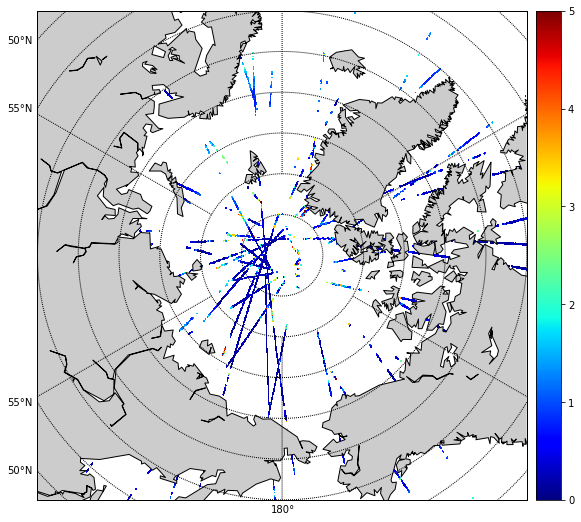

In [152]:
plt.figure(1,figsize=(16, 9))
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
m_west = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
xi, yi = m(x_map, y_map)
xi_west ,yi_west = m(x_map_west, y_map_west)

# Draw the scatterplot
h = m.pcolor(xi ,yi, data=swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = m.pcolor(xi_west ,yi_west, data=swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)

# 2.HY-2B有效波高显示

In [129]:

hy_dir_path = 'E:\python_workfile\\remote_sensing\H2B_nc_data\H2B_20200711'
hyfiles = glob.glob(hy_dir_path + '\*.nc')
hy_lon_array = np.array([])
hy_lat_array = np.array([])
hy_swh_array = np.array([])
hy_swhc_mask_array = np.array([])
for hyfile in hyfiles:
    fh = Dataset(hyfile, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    swhc = fh.variables['swh_c'][:]
    swhc_mask = swhc.mask
    hy_lon_array = np.append(hy_lon_array, lons)
    hy_lat_array = np.append(hy_lat_array, lats)
    hy_swh_array = np.append(hy_swh_array, swhc)
    hy_swhc_mask_array = np.append(hy_swhc_mask_array, swhc_mask)
    fh.close()
hy_swhc_array_masked = np.ma.array(hy_swh_array, mask=hy_swhc_mask_array)


In [130]:
transformer = pyproj.Transformer.from_crs(crs,crs2)
hy_projlats,hy_projlons = transformer.transform(hy_lat_array,hy_lon_array)

In [131]:
# 设置空间分辨率
resolution = 10000
hy_nlat, hy_nlon =(hy_projlats.max()-hy_projlats.min())/resolution, (hy_projlons.max() - hy_projlons.min())/resolution
hy_nlat = np.int(hy_nlat)
hy_nlon = np.int(hy_nlon)
hy_swh_grid = np.full(shape=(hy_nlon,hy_nlat), fill_value=np.nan)

hy_swh_grid_num = np.zeros((hy_nlon,hy_nlat))

In [132]:
# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
for i in range(len(hy_swhc_array_masked)):
    x = int(hy_projlons[i]/resolution)
    y = int(hy_projlats[i]/resolution)
    
    if hy_swh_grid_num[x][y] == 0:
        hy_swh_grid[x][y] = hy_swhc_array_masked[i]
        hy_swh_grid_num[x][y] += 1
    else:
        hy_swh_grid[x][y] += hy_swhc_array_masked[i]
        hy_swh_grid_num[x][y] += 1
hy_swh_grid = hy_swh_grid / hy_swh_grid_num

<ipython-input-132-aa1d0875df3b>:7: UserWarning: Warning: converting a masked element to nan.
  hy_swh_grid[x][y] = hy_swhc_array_masked[i]
<ipython-input-132-aa1d0875df3b>:10: UserWarning: Warning: converting a masked element to nan.
  hy_swh_grid[x][y] += hy_swhc_array_masked[i]


### 制作西半球数组

In [133]:
hy_lon_array_west = hy_lon_array - 180
hy_lat_array_west = hy_lat_array

In [134]:
transformer = pyproj.Transformer.from_crs(crs,crs2)
hy_projlats_west,hy_projlons_west = transformer.transform(hy_lat_array_west,hy_lon_array_west)

In [135]:

hy_nlat_west, hy_nlon_west =(hy_projlats.max()-hy_projlats.min())/resolution, (hy_projlons.max() - hy_projlons.min())/resolution
hy_nlat_west = np.int(hy_nlat_west)
hy_nlon_west = np.int(hy_nlon_west)
hy_swh_grid_west = np.full(shape=(hy_nlon_west,hy_nlat_west), fill_value=np.nan)

hy_swh_grid_num_west = np.zeros((hy_nlon,hy_nlat))

In [136]:
for i in range(len(hy_swhc_array_masked)):
    x = int(hy_projlons_west[i]/resolution)
    y = int(hy_projlats_west[i]/resolution)
    if hy_swh_grid_num_west[x][y] == 0:
        hy_swh_grid_west[x][y] = hy_swhc_array_masked[i]
        hy_swh_grid_num_west[x][y] += 1
    else:
        hy_swh_grid_west[x][y] += hy_swhc_array_masked[i]
        hy_swh_grid_num_west[x][y] += 1
hy_swh_grid_west = hy_swh_grid_west / hy_swh_grid_num_west

<ipython-input-136-9d5dfd96a040>:5: UserWarning: Warning: converting a masked element to nan.
  hy_swh_grid_west[x][y] = hy_swhc_array_masked[i]
<ipython-input-136-9d5dfd96a040>:8: UserWarning: Warning: converting a masked element to nan.
  hy_swh_grid_west[x][y] += hy_swhc_array_masked[i]


In [137]:
# 校准y坐标
hy_x_west = np.arange(hy_nlat_west)
hy_y_west = np.arange(hy_nlon_west) 
hy_xx_west , hy_yy_west = np.meshgrid(hy_x_west * resolution, hy_y_west * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
hy_y_map_west, hy_x_map_west = transformer_back.transform(hy_xx_west , hy_yy_west)
hy_x_map_west = hy_x_map_west-180

<ipython-input-139-1007178fafb8>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-139-1007178fafb8>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = hy_m.pcolor(hy_xi_west ,hy_yi_west, data=hy_swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)


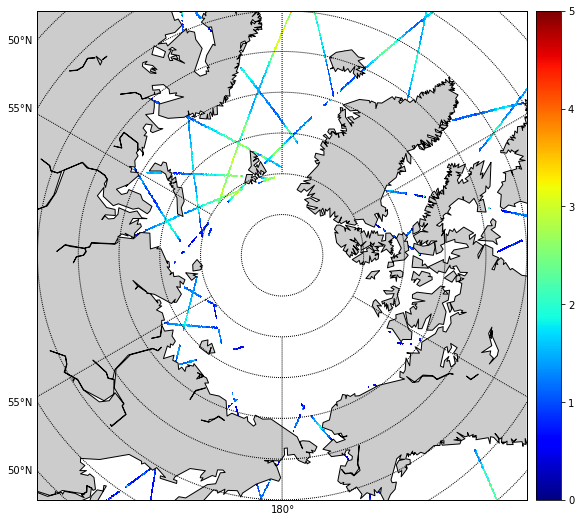

In [139]:
plt.figure(1,figsize=(16, 9))
# hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
hy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')

hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)
hy_xi_west ,hy_yi_west = hy_m(hy_x_map_west, hy_y_map_west)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = hy_m.pcolor(hy_xi_west ,hy_yi_west, data=hy_swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
hy_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)

<ipython-input-155-819c83d3ba43>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-155-819c83d3ba43>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = hy_m.pcolor(hy_xi_west ,hy_yi_west, data=hy_swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-155-819c83d3ba43>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions 

Text(0.5, 1.0, 'ICESAT-2 Significant Wave Height')

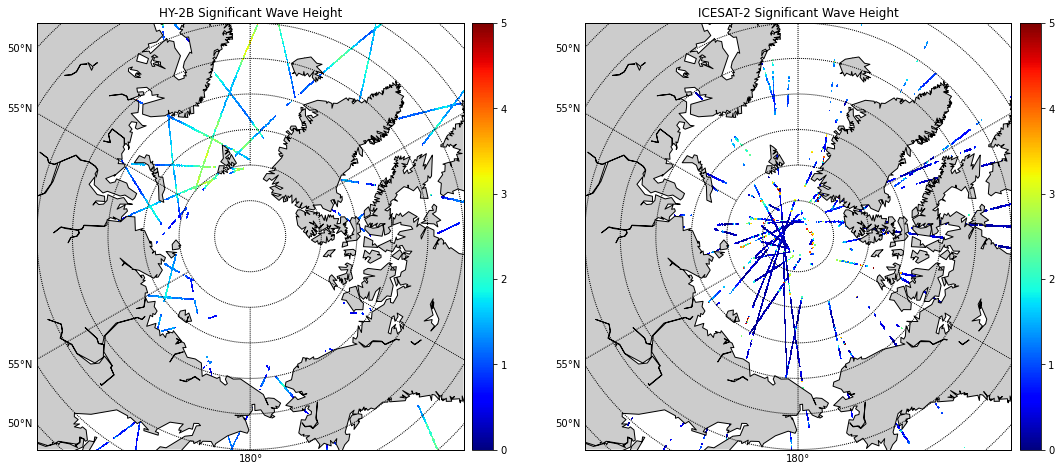

In [155]:
fig = plt.figure(3)    # 生成新的画布fig
fig.set_size_inches(18, 18)     # 调整画布为合适大小

ax1 = fig.add_subplot(121) 
hy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')

hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)
hy_xi_west ,hy_yi_west = hy_m(hy_x_map_west, hy_y_map_west)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = hy_m.pcolor(hy_xi_west ,hy_yi_west, data=hy_swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
hy_m.colorbar(location='right')

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])


plt.title("HY-2B Significant Wave Height")


ax2 = fig.add_subplot(122)
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
m_west = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
xi, yi = m(x_map, y_map)
xi_west ,yi_west = m(x_map_west, y_map_west)

# Draw the scatterplot
h = m.pcolor(xi ,yi, data=swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = m.pcolor(xi_west ,yi_west, data=swh_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("ICESAT-2 Significant Wave Height")

# 3.CryoSat-2有效波高显示

CryoSat-2的有效波高只提供了Ku波段的，HY-2B的有效波高提供了C波段和Ku波段

In [174]:
cy_dir_path = 'F:\remote_sensing_data\CRYOSAT-2\20200711'
cyfiles = glob.glob(cy_dir_path + '\*.nc')
cy_lon_array = np.array([])
cy_lon_array_lat_array = np.array([])
cy_swh_array = np.array([])
cy_swh_mask_array = np.array([])
for cyfile in cyfiles:
    fh = Dataset(cyfile, mode='r')
    lons = fh.variables['lon_01'][:]
    lats = fh.variables['lat_01'][:]
    swh = fh.variables['swh_ocean_01_ku'][:]
    swh_mask = swh_ocean_01_ku.mask
    cy_lon_array = np.append(cy_lon_array, lons)
    cy_lat_array = np.append(cy_lat_array, lats)
    cy_swh_array = np.append(cy_swh_array, swh)
    cy_swh_mask_array = np.append(cy_swh_mask_array, swh_mask)
    fh.close()
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)



In [168]:
cy_dir_path = 'F:\\remote_sensing_data\\CRYOSAT-2\\20200711\\CS_OFFL_SIR_LRM_2__20200711T013040_20200711T015320_D001.nc'
with Dataset(cy_dir_path, mode='r') as fh:
    lons = fh.variables['lon_01'][:]
    lats = fh.variables['lat_01'][:]
    swh = fh.variables['swh_ocean_01_ku'][:]


In [163]:
lons

masked_array(data=[-17.3659605, -17.3727192, -17.3794744, ...,
                   -26.742552 , -26.7514172, -26.7602942],
             mask=False,
       fill_value=1e+20)

In [177]:
swh

masked_array(data=[1.994, 2.027, 2.008, ..., 1.663, 1.5150000000000001,
                   1.804],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-32768)